In [1]:
import cupy as cp

try:
    cp.cuda.Device(0).use()
    print("CUDA is available. Using GPU for computations.")
except cp.cuda.runtime.CUDARuntimeError:
    print("CUDA is not available. Falling back to CPU with NumPy.")
    import numpy as np
    cp = np 


CUDA is available. Using GPU for computations.


2. Data Loading and Preprocessing

In [6]:
import cupy as cp
import numpy as np
from collections import Counter
import random
import re
from datasets import load_dataset
from tqdm import tqdm
import pickle

# Function to switch between CuPy and NumPy based on availability
def get_array_module(x):
    return cp.get_array_module(x)

def tokenize(text):
    return re.findall(r'\b[a-z]{1,}\b', text.lower())

print("Loading WikiText-2 dataset...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_text = ' '.join(dataset['train']['text'])

print("Tokenizing text...")
tokens = tokenize(train_text)
print(f"Total tokens before subsampling: {len(tokens)}")


Loading WikiText-2 dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing text...
Total tokens before subsampling: 1679656


In [7]:
vocab_size = 1000000
print(f"Building vocabulary of top {vocab_size} words...")
counter = Counter(tokens)
most_common = counter.most_common(vocab_size - 1)  # Reserve index 0 for <UNK>
word2idx = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
word2idx['<UNK>'] = 0
idx2word = {idx: word for word, idx in word2idx.items()}

print("Converting tokens to indices...")
token_indices = [word2idx.get(token, 0) for token in tokens]
del tokens
print(f"Total token indices before subsampling: {len(token_indices)}")

Building vocabulary of top 1000000 words...
Converting tokens to indices...
Total token indices before subsampling: 1679656


In [8]:
def subsample(token_indices, counter, idx2word, threshold=1e-5):
    total_count = sum(counter.values())
    word_freq = {word: count / total_count for word, count in counter.items()}
    # Calculate discard probability for each word
    discard_prob = {word: 1 - cp.sqrt(threshold / freq) for word, freq in word_freq.items()}
    # Replace words with probability of being discarded
    subsampled = []
    for idx in tqdm(token_indices, desc="Subsampling"):
        word = idx2word.get(idx, '<UNK>')
        prob = discard_prob.get(word, 0)
        if random.random() > prob:
            subsampled.append(idx)
    return subsampled

print("Applying subsampling to reduce the number of training pairs...")
subsampled_token_indices = subsample(token_indices, counter, idx2word, threshold=1e-5)
print(f"Total tokens after subsampling: {len(subsampled_token_indices)}")
del token_indices  

Applying subsampling to reduce the number of training pairs...


Subsampling: 100%|██████████| 1679656/1679656 [01:46<00:00, 15716.44it/s]


Total tokens after subsampling: 479964


In [9]:
def generate_training_pairs(token_indices, window_size=5, max_context=3):
    pairs = []
    for idx, target in enumerate(token_indices):
        window = random.randint(1, window_size)
        start = max(idx - window, 0)
        end = min(idx + window + 1, len(token_indices))
        contexts = [token_indices[i] for i in range(start, end) if i != idx]
        if len(contexts) > max_context:
            contexts = random.sample(contexts, max_context)
        for context in contexts:
            pairs.append((target, context))
    return pairs #(target, context)

print("Generating training pairs with limited context...")
training_pairs = generate_training_pairs(subsampled_token_indices, window_size=5, max_context=3)
print(f"Total training pairs after limiting context: {len(training_pairs)}")
del subsampled_token_indices

print("Shuffling training pairs...")
random.shuffle(training_pairs)


Generating training pairs with limited context...
Total training pairs after limiting context: 1343980
Shuffling training pairs...


In [ ]:
def sample_training_pairs(training_pairs, sample_fraction=0.1):
    sample_size = int(len(training_pairs) * sample_fraction)
    sampled_pairs = random.sample(training_pairs, sample_size)
    return sampled_pairs


In [10]:
print("Sampling a subset of training pairs...")
training_pairs_sampled = sample_training_pairs(training_pairs, sample_fraction=0.1)
print(f"Total training pairs after sampling: {len(training_pairs_sampled)}")
del training_pairs 


print("Shuffling sampled training pairs...")
random.shuffle(training_pairs_sampled)

Sampling a subset of training pairs...
Total training pairs after sampling: 134398
Shuffling sampled training pairs...


In [11]:
def create_unigram_distribution(pairs, vocab_size):
    word_counts = Counter([pair[1] for pair in pairs])
    # Including all words in the vocabulary
    counts = cp.array([word_counts.get(i, 0) for i in range(vocab_size)])
    unigram_dist = cp.power(counts, 0.75)
    unigram_dist /= cp.sum(unigram_dist)
    return unigram_dist

print("Creating unigram distribution for negative sampling...")
unigram_dist = create_unigram_distribution(training_pairs_sampled, vocab_size)

def get_negative_samples(unigram_dist, num_negatives):
    negatives = cp.random.choice(
        a=cp.arange(len(unigram_dist)),
        size=num_negatives,
        replace=True,
        p=unigram_dist
    )
    return negatives

Creating unigram distribution for negative sampling...


In [12]:
embedding_dim = 100  # Because i did not want to use 300
print(f"Initializing embeddings with dimension {embedding_dim}...")

# Initialize embeddings with small random values on the GPU
target_embeddings = (cp.random.rand(vocab_size, embedding_dim) - 0.5) / embedding_dim
context_embeddings = (cp.random.rand(vocab_size, embedding_dim) - 0.5) / embedding_dim

learning_rate = 0.025
num_epochs = 5
num_negatives = 5

print("Starting training...")
for epoch in range(num_epochs):
    total_loss = 0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for pair in tqdm(training_pairs_sampled, desc=f"Epoch {epoch+1}", unit="pair"):
        target, context = pair

        # Convert to CuPy arrays
        v_target = target_embeddings[target]  # Shape: (embedding_dim,)
        v_context = context_embeddings[context]  # Shape: (embedding_dim,)

        # Compute cosine similarity for positive pair
        dot_pos = cp.dot(v_target, v_context)
        norm_target = cp.linalg.norm(v_target) + 1e-8
        norm_context = cp.linalg.norm(v_context) + 1e-8
        cos_sim = dot_pos / (norm_target * norm_context)

        # Loss for positive pair: maximize cosine similarity
        loss_pos = -cos_sim  # Negative because we'll minimize the loss

        # Gradient for positive pair
        grad_target_pos = -v_context / (norm_target * norm_context)
        grad_context_pos = -v_target / (norm_target * norm_context)

        # Negative samples
        negative_samples = get_negative_samples(unigram_dist, num_negatives)
        loss_neg = 0
        grad_target_neg = cp.zeros(embedding_dim)
        grad_context_neg = cp.zeros(embedding_dim)

        for neg in negative_samples:
            v_neg = context_embeddings[neg]
            dot_neg = cp.dot(v_target, v_neg)
            norm_neg = cp.linalg.norm(v_neg) + 1e-8
            cos_sim_neg = dot_neg / (norm_target * norm_neg)
            # Loss for negative pair: minimize cosine similarity
            loss_neg += cos_sim_neg
            # Gradients
            grad_target_neg += v_neg / (norm_target * norm_neg)
            grad_context_neg += v_target / (norm_target * norm_neg)

        # Total loss
        total_loss += loss_pos + loss_neg

        # Update embeddings
        # For target
        target_embeddings[target] -= learning_rate * (grad_target_pos + grad_target_neg / num_negatives)
        # For positive context
        context_embeddings[context] -= learning_rate * grad_context_pos
        # For negative contexts
        for neg in negative_samples:
            context_embeddings[neg] -= learning_rate * grad_context_neg / num_negatives

    avg_loss = total_loss / len(training_pairs_sampled)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

Initializing embeddings with dimension 100...
Starting training...
Epoch 1/5


Epoch 1: 100%|██████████| 134398/134398 [15:59<00:00, 140.07pair/s]


Epoch 1 completed. Average Loss: -0.0012
Epoch 2/5


Epoch 2: 100%|██████████| 134398/134398 [15:49<00:00, 141.61pair/s]


Epoch 2 completed. Average Loss: -0.2656
Epoch 3/5


Epoch 3: 100%|██████████| 134398/134398 [15:48<00:00, 141.70pair/s]


Epoch 3 completed. Average Loss: -0.3118
Epoch 4/5


Epoch 4: 100%|██████████| 134398/134398 [15:50<00:00, 141.33pair/s]


Epoch 4 completed. Average Loss: -0.3457
Epoch 5/5


Epoch 5: 100%|██████████| 134398/134398 [15:48<00:00, 141.72pair/s]

Epoch 5 completed. Average Loss: -0.3710


In [13]:
print("Saving embeddings...")

# Move embeddings back to CPU before saving
target_embeddings_cpu = cp.asnumpy(target_embeddings)
context_embeddings_cpu = cp.asnumpy(context_embeddings)

# Save target embeddings
with open('target_embeddings.pkl', 'wb') as f:
    pickle.dump(target_embeddings_cpu, f)

# Save context embeddings (optional, often they are averaged or used similarly)
with open('context_embeddings.pkl', 'wb') as f:
    pickle.dump(context_embeddings_cpu, f)

# Save word2idx and idx2word mappings
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)
with open('idx2word.pkl', 'wb') as f:
    pickle.dump(idx2word, f)

print("Embeddings and mappings saved successfully!")

# Example: Get embedding for a word
def get_embedding(word, target_embeddings, word2idx):
    idx = word2idx.get(word, 0)
    return target_embeddings[idx]

# Example usage
word = 'king'
embedding_vector = get_embedding(word, target_embeddings_cpu, word2idx)
print(f"Embedding for '{word}':\n{embedding_vector}")


Saving embeddings...
Embeddings and mappings saved successfully!
Embedding for 'king':
[ 0.25319154 -0.10480334  0.05608741 -0.12154691  0.16173901 -0.19112533
 -0.19911333  0.17236949 -0.14079342 -0.07652453 -0.14008694 -0.08599303
 -0.17633325 -0.27720974 -0.11459997 -0.20571932 -0.07815922 -0.06257325
  0.17619794  0.16002222 -0.08929375  0.19320422  0.08242549  0.0608637
  0.20396616  0.12349945  0.19482592 -0.31755626  0.18003472 -0.14307424
 -0.14351436 -0.11006684  0.26994098 -0.00248645  0.09458753 -0.01020293
  0.17901427  0.06760835  0.18737782  0.1535133  -0.02559486 -0.0839262
  0.10302374  0.09658467  0.00287058  0.10080916 -0.0484813  -0.06375392
  0.08406784  0.07375439  0.02933999 -0.21410278 -0.00220187  0.17712897
  0.02680553 -0.00502083 -0.0789853   0.13523891  0.09473762 -0.00636836
  0.01842447  0.11023365  0.12963847 -0.14832293  0.06000807 -0.14896583
  0.11565781  0.23363588 -0.09004201 -0.04087621  0.04278331  0.09327549
 -0.08193988  0.15435127 -0.02202644 -0

In [ ]:
import pandas as pd

simlex_path = 'SimLex-999.txt'  

try:
    simlex_df = pd.read_csv(simlex_path, sep='\t')
    print("Loaded SimLex-999 dataset successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"SimLex-999 file not found at {simlex_path}. Please upload the SimLex-999.txt file.")


In [17]:
print("\nFirst few entries in SimLex-999:")
print(simlex_df.head())
required_columns = {'word1', 'word2', 'SimLex999'}
if not required_columns.issubset(simlex_df.columns):
    raise ValueError(f"SimLex-999 file must contain the columns: {required_columns}")


Loaded SimLex-999 dataset successfully.

First few entries in SimLex-999:
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  


Loaded 'idx2word.pkl' successfully.
Embeddings and mappings loaded successfully!
Shape of target_embeddings: (1000000, 100)
target_embeddings is already a NumPy array.
Loaded SimLex-999 dataset successfully.

First few entries in SimLex-999:
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  
Processed 985 out of 999 word pairs.
Spearman's rank correlation: -0.0074
P-value: 0.8166


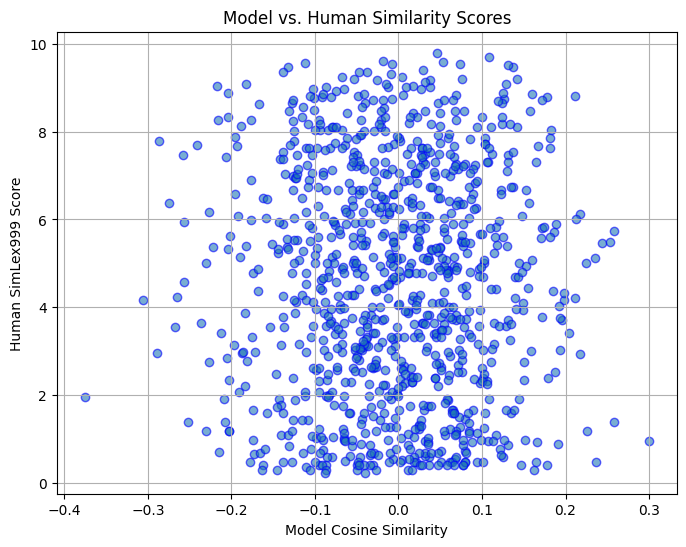

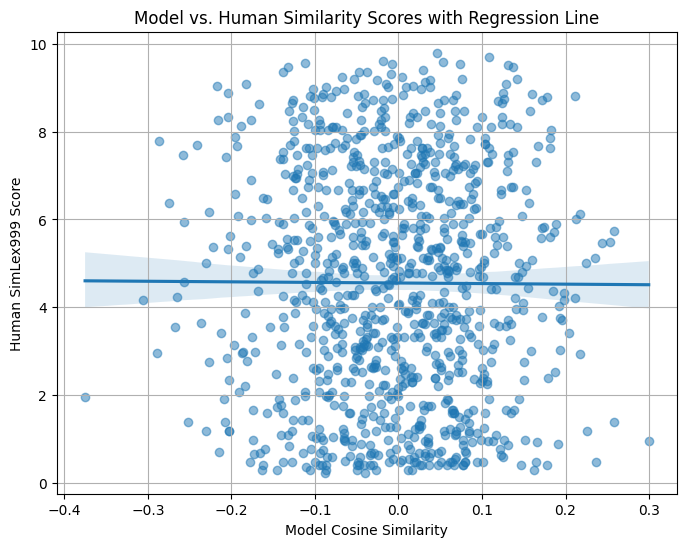

In [23]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import cupy as cp 

with open('target_embeddings.pkl', 'rb') as f:
    target_embeddings = pickle.load(f)

with open('word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)

try:
    with open('idx2word.pkl', 'rb') as f:
        idx2word = pickle.load(f)
    print("Loaded 'idx2word.pkl' successfully.")
except FileNotFoundError:
    print("'idx2word.pkl' not found. Proceeding without it.")

print("Embeddings and mappings loaded successfully!")
print(f"Shape of target_embeddings: {target_embeddings.shape}")

if isinstance(target_embeddings, cp.ndarray):
    target_embeddings = target_embeddings.get()  # Convert to NumPy array
    print("Converted target_embeddings to NumPy array.")
else:
    print("target_embeddings is already a NumPy array.")

simlex_path = 'SimLex-999.txt'  
try:
    simlex_df = pd.read_csv(simlex_path, sep='\t')
    print("Loaded SimLex-999 dataset successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"SimLex-999 file not found at {simlex_path}. Please upload the SimLex-999.txt file.")

print("\nFirst few entries in SimLex-999:")
print(simlex_df.head())

# Check for necessary columns
required_columns = {'word1', 'word2', 'SimLex999'}
if not required_columns.issubset(simlex_df.columns):
    raise ValueError(f"SimLex-999 file must contain the columns: {required_columns}")


from sklearn.metrics.pairwise import cosine_similarity

def get_embedding(word, embeddings, word2idx):
    idx = word2idx.get(word.lower(), None)  # Assuming your vocabulary is in lowercase
    if idx is not None:
        return embeddings[idx]
    else:
        return None
human_scores = []
model_scores = []

# Iterate over each row in the SimLex dataset
for index, row in simlex_df.iterrows():
    word1 = row['word1'].lower()
    word2 = row['word2'].lower()
    human_score = row['SimLex999']

    emb1 = get_embedding(word1, target_embeddings, word2idx)
    emb2 = get_embedding(word2, target_embeddings, word2idx)

    if emb1 is not None and emb2 is not None:
        # Ensure embeddings are NumPy arrays
        if isinstance(emb1, cp.ndarray):
            emb1 = emb1.get()
        if isinstance(emb2, cp.ndarray):
            emb2 = emb2.get()

        # Reshape embeddings for cosine_similarity function
        emb1 = emb1.reshape(1, -1)
        emb2 = emb2.reshape(1, -1)

        # Compute cosine similarity
        cos_sim = cosine_similarity(emb1, emb2)[0][0]

        # Append scores
        human_scores.append(human_score)
        model_scores.append(cos_sim)
    else:
        # Skip pairs where at least one word is not in the vocabulary
        pass

print(f"Processed {len(model_scores)} out of {len(simlex_df)} word pairs.")

spearman_corr, p_value = spearmanr(human_scores, model_scores)

print(f"Spearman's rank correlation: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(model_scores, human_scores, alpha=0.6, edgecolors='b')
plt.xlabel('Model Cosine Similarity')
plt.ylabel('Human SimLex999 Score')
plt.title('Model vs. Human Similarity Scores')
plt.grid(True)
plt.show()

plot_df = pd.DataFrame({
    'Model_Similarity': model_scores,
    'Human_Score': human_scores
})

plt.figure(figsize=(8, 6))
sns.regplot(x='Model_Similarity', y='Human_Score', data=plot_df, scatter_kws={'alpha':0.5})
plt.xlabel('Model Cosine Similarity')
plt.ylabel('Human SimLex999 Score')
plt.title('Model vs. Human Similarity Scores with Regression Line')
plt.grid(True)
plt.show()
